In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

In [2]:
# if u wanna run tf on CPU 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# enabling memory growth on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('number of GPUs available', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

number of GPUs available 1


In [3]:
# # organise data into train, validation and test directories
# os.chdir('dogs-vs-cats')
# if os.path.isdir('train/dogs') is False:
#     os.makedirs('train/dogs')
#     os.makedirs('test/dogs')
#     os.makedirs('valid/dogs')
#     os.makedirs('train/cats')
#     os.makedirs('test/cats')
#     os.makedirs('valid/cats')
    
#     for c in random.sample(glob.glob('cat*'), 500):
#         shutil.move(c, 'train/cats')
#     for c in random.sample(glob.glob('dog*'), 500):
#         shutil.move(c, 'train/dogs')
#     for c in random.sample(glob.glob('cat*'), 100):
#         shutil.move(c, 'valid/cats')
#     for c in random.sample(glob.glob('dog*'), 100):
#         shutil.move(c, 'valid/dogs')
#     for c in random.sample(glob.glob('cat*'), 50):
#         shutil.move(c, 'test/cats')
#     for c in random.sample(glob.glob('dog*'), 50):
#         shutil.move(c, 'test/dogs')
# os.chdir('..')

In [4]:
train_path = 'dogs-vs-cats/train'
test_path = 'dogs-vs-cats/test'
valid_path = 'dogs-vs-cats/valid'

In [5]:
# this code preprocess the images using vgg16 preprocess function
# this function subtracts the mean value of rgb from all the train images and subtract the mean values from all the images
# target_size is the size of the image specified by us
# every image is resized to the target_size, which helps in uniformity and to stucture the input nodes
# below code creates batches of data
# ImageDataGenerator.flow_from_directory() creates a DirectoryIterator, 
# which generates batches of normalized tensor image data from the respective data directories.

# actual test dir from kaggle don't have labels, wat to do then
# Note, in the case where you do not know the labels for the test data, 
# you will need to modify the test_batches variable. 
# Specifically, the change will be to set the parameters classes = None and class_mode = None in flow_from_directory().

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
# now we are gonna grab a single batch of images
images, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

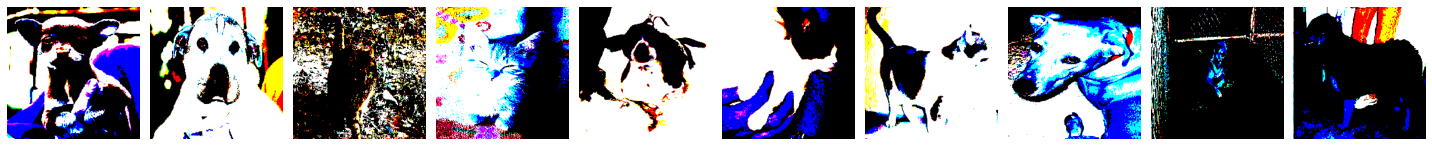

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
plotImages(images)
print(labels)

In [9]:
%%time
# Build and train a CNN

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

CPU times: user 2min 38s, sys: 364 ms, total: 2min 38s
Wall time: 2min 38s


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [94]:
# we use categorical_crossentropy when there is more than 2 class - it is for general purpose
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
%%time
# we don't specify y here bcz
# ImageGenerator merges labels in train_batches itself
# tf knows where to look for labels

model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=2,
    verbose=2
)

Epoch 1/2
100/100 - 21s - loss: 18.2325 - accuracy: 0.5620 - val_loss: 7.8182 - val_accuracy: 0.5750
Epoch 2/2
100/100 - 16s - loss: 2.5310 - accuracy: 0.7420 - val_loss: 3.6572 - val_accuracy: 0.6400
CPU times: user 32.4 s, sys: 3.96 s, total: 36.4 s
Wall time: 1min 2s


In [96]:
print(len(train_batches))
print(len(valid_batches))

100
20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

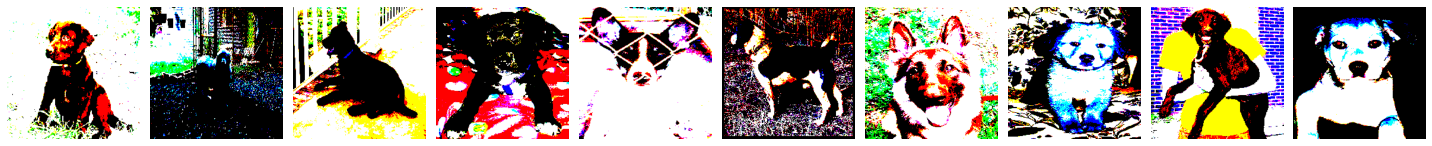

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [97]:
# Prediction
test_images, test_labels = next(test_batches)
plotImages(test_images)
print(test_labels)

In [111]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [118]:
prediction = model.predict(x=test_batches, steps=len(test_batches), verbose = 1)

10/10 [==============================] - 1s 52ms/step


In [119]:
prediction

array([[4.2073843e-05, 9.9995792e-01],
       [9.9972838e-01, 2.7159913e-04],
       [1.9163167e-03, 9.9808371e-01],
       [7.5222388e-08, 9.9999988e-01],
       [9.8797137e-01, 1.2028645e-02],
       [9.9892151e-01, 1.0784576e-03],
       [9.9999392e-01, 6.0398565e-06],
       [9.9874878e-01, 1.2511832e-03],
       [9.9999785e-01, 2.1972680e-06],
       [4.2102045e-07, 9.9999952e-01],
       [7.0339076e-05, 9.9992967e-01],
       [4.7715326e-07, 9.9999952e-01],
       [9.8726618e-01, 1.2733872e-02],
       [2.7678194e-03, 9.9723214e-01],
       [1.0000000e+00, 1.7488087e-08],
       [7.3686078e-11, 1.0000000e+00],
       [9.9997628e-01, 2.3677334e-05],
       [2.7488348e-01, 7.2511649e-01],
       [4.0838186e-05, 9.9995911e-01],
       [2.9939557e-08, 1.0000000e+00],
       [5.3689519e-09, 1.0000000e+00],
       [9.9998534e-01, 1.4681940e-05],
       [6.8282403e-05, 9.9993169e-01],
       [2.6043044e-02, 9.7395700e-01],
       [9.7954935e-01, 2.0450607e-02],
       [9.9968231e-01, 3.

In [120]:
np.round(prediction)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [121]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [122]:
cm = confusion_matrix(test_batches.classes, np.argmax(prediction, axis = -1))

In [123]:
cm

array([[19, 31],
       [14, 36]])

In [8]:
# now we move on to famous pretrained models

In [13]:
# VGG16
# this model won 2014 imagenet competetion
# model storage is large nearly 553mb
# not suitable for mobile use

In [14]:
# Download - internet connection needed
with tf.device('/cpu:0'):    
    vgg16_model = tf.keras.applications.vgg16.VGG16()

In [15]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# vgg model we imported above is in functional api and not sequential api
# we convert it into sequential excluding last output layer
our_model = Sequential()
for layer in vgg16_model.layers[:-1]:
    our_model.add(layer)

In [17]:
our_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [18]:
# now we will freeze all the layers so when we train the model nothing changes in the freezed layer
# all the weights and biases remains the same
# bcz we want the weights of it's original training weights, bcz it had trained on huge amount of images on imagenet website
for layer in our_model.layers:
    layer.trainable = False

In [19]:
our_model.add(Dense(units = 2, activation = 'softmax'))

In [20]:
our_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [21]:
# therefore now we can see that output layer is our only trainable layer
our_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
np.random.seed(0)

In [23]:
with tf.device('/cpu:0'):
    our_model.fit(x=train_batches,
              steps_per_epoch=len(train_batches),
              validation_data=valid_batches,
              validation_steps=len(valid_batches),
              epochs=2,
              verbose=2
    )

Epoch 1/2
100/100 - 333s - loss: 0.3718 - accuracy: 0.8460 - val_loss: 0.1680 - val_accuracy: 0.9400
Epoch 2/2
100/100 - 336s - loss: 0.0709 - accuracy: 0.9750 - val_loss: 0.1633 - val_accuracy: 0.9350


In [32]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 100 images belonging to 2 classes.


In [33]:
with tf.device('/cpu:0'):
    predictions = our_model.predict(x=test_batches, steps=len(test_batches), verbose=1)

10/10 [==============================] - 20s 2s/step


In [34]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [35]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
cm = confusion_matrix(test_batches.classes, np.argmax(predictions, axis=-1))

In [37]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [38]:
cm

array([[49,  1],
       [ 2, 48]])

In [48]:
# we will start mobile net
# 17mb

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils

In [4]:
# we need internet connection for this
mobile = tf.keras.applications.mobilenet.MobileNet()

In [5]:
# i will write a function below that will process a raw image as a input to mobilenet model
#load_img function image is from keras api
# what we are doing here is
# 1. resize the image to 224,224
# 2. convert image to array
# 3. expand the array - changing it's dimensions
# 4. processing the image array using mobile net preprocess function
def prepare_image(file_name):
    image_path = 'sample-images/'
    img = image.load_img(image_path+file_name, target_size = (224,224))
    # we convert image to array
    image_array = image.img_to_array(img)
    # we will change the shape of image_array to a shape that our mobilenet expects
    image_array_expanded = np.expand_dims(image_array, axis=0)
    mobilenet_processed_image = tf.keras.applications.mobilenet.preprocess_input(image_array_expanded)
    return mobilenet_processed_image

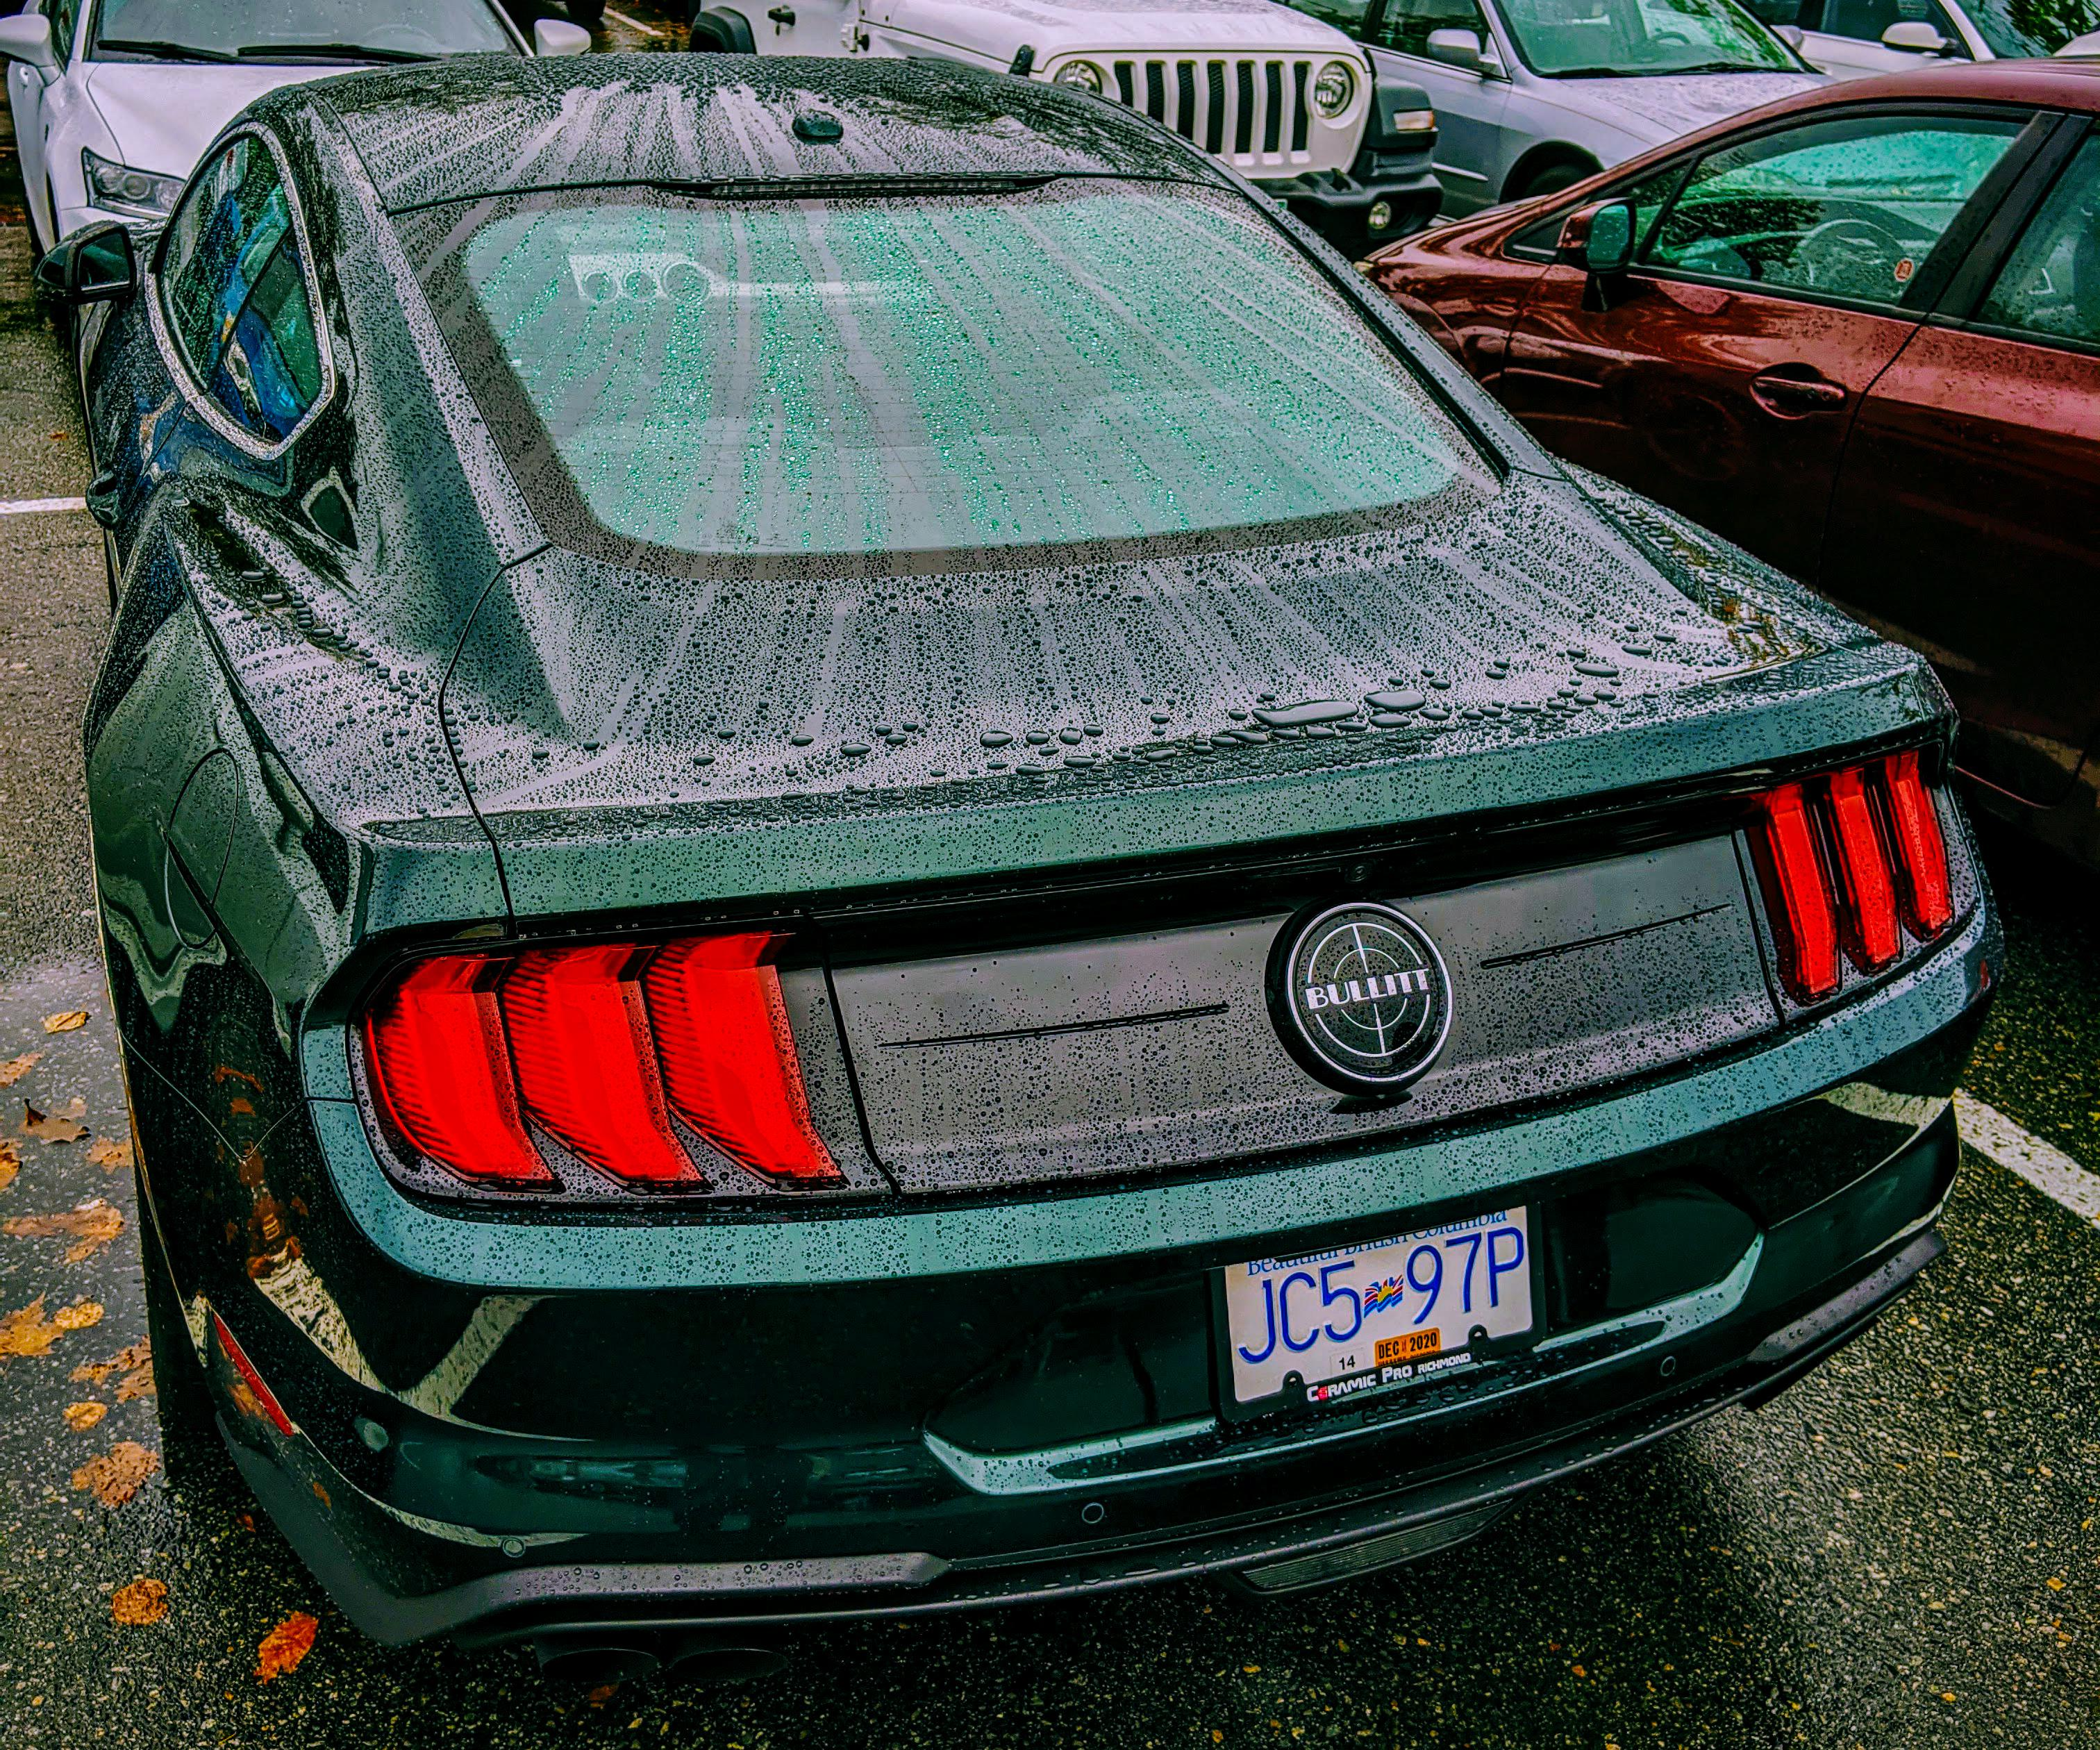

In [6]:
# display image using ipython functions
from IPython.display import Image
Image(filename = 'sample-images/mustang.jpg', width=224, height=224)

In [ ]:
preprocessed_image = prepare_image('mustang.jpg')
prediction = mobile.predict(preprocessed_image)
prediction.shape

In [ ]:
# Then, we’re using an ImageNet utility function provided by Keras called decode_predictions(). 
# It returns the top five ImageNet class predictions with the ImageNet class ID, 
# the class label, and the probability. 
# With this, we’ll be able to see the five ImageNet classes with the highest prediction probabilities from our model on this given image. 
# Recall that there are 1000 total ImageNet classes.
# we need internet for this step
results = imagenet_utils.decode_predictions(prediction)
results

In [9]:
# let's train mobile net with our custom dataset which the mobilenet has never seen before, theseimages are not part of imagenet

In [10]:
# # Organize data into train, valid, test dirs
# os.chdir('sign-language-digits/')
# if os.path.isdir('train/0/') is False: 
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')

#     for i in range(0, 10):
#         shutil.move(f'{i}', 'train')
#         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')

#         valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}', f'valid/{i}')

#         test_samples = random.sample(os.listdir(f'train/{i}'), 5)
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('..')

In [11]:
train_path = 'sign-language-digits/train'
test_path = 'sign-language-digits/test'
valid_path = 'sign-language-digits/valid'

In [12]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [13]:
train_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [14]:
# Modify the model

In [15]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [18]:
# we will all the layers except the last 5 layers

# we will follow functional api rather than sequential api now

# we’re going to grab the output from the sixth to last layer of the model and store it in this variable x
x = mobile.layers[-6].output
# output is all the mobile net model up until the last 6th layer + the the dense output layer with 10 units
output = Dense(units = 10, activation = 'softmax')(x)

In [19]:
# mobile.input provides the input layer
# output contains all the hidden and output layers
our_new_model = Model(inputs = mobile.input, outputs = output)

In [20]:
# we will freeze all the layers except the last 23 layers
for layer in our_new_model.layers[:-23]:
    layer.trainable = False

In [21]:
our_new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [24]:
# compilation
our_new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
# we will train the model now

In [26]:
our_new_model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=2,
            verbose=2
)

Epoch 1/2
172/172 - 107s - loss: 0.3283 - accuracy: 0.8890 - val_loss: 2.2526 - val_accuracy: 0.5100
Epoch 2/2
172/172 - 112s - loss: 0.0691 - accuracy: 0.9731 - val_loss: 0.1313 - val_accuracy: 0.9733


In [27]:
# here goes the prediction

In [28]:
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [29]:
predictions = our_new_model.predict(x = test_batches, steps = len(test_batches), verbose = 1)

5/5 [==============================] - 1s 250ms/step


In [30]:
np.argmax(predictions, axis = -1)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9])

In [31]:
cm = confusion_matrix(test_batches.classes, np.argmax(predictions, axis = -1))

In [32]:
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])

In [33]:
# new-topic - Data Augmentation
# data augmentation is artificially creating images from our existing images
# this helps when we have very low dataset

In [2]:
# plot the images in a row with 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
# the parameters given below helps us to augment data
gen = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.15, 
                         zoom_range=0.1, 
                         channel_shift_range=10., 
                         horizontal_flip=True)

In [4]:
# we will randomly choose a dog image
chosen_image = random.choice(os.listdir('dogs-vs-cats/train/dogs'))
image_path = 'dogs-vs-cats/train/dogs/' + chosen_image

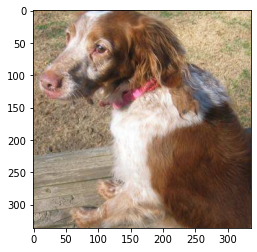

In [5]:
plt.imshow(plt.imread(image_path))

In [6]:
# make the image compatible for imagedatagenerator
image = np.expand_dims(plt.imread(image_path),0)

In [10]:
# well generate batches of augmented images from the original image.
# The flow() function takes numpy data and generates batches of augmented data.

# Now we’ll get ten samples of the augmented images.
aug_iter = gen.flow(image)

In [11]:
# get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

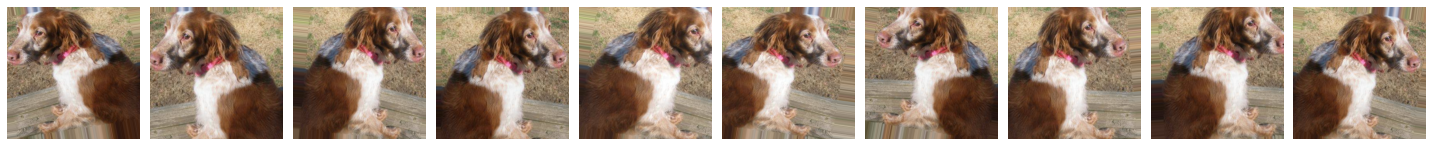

In [12]:
# plot the samples
plotImages(aug_images)

In [18]:
# save the augmented images
# we can give number of images wanted inside range, it can be any number
# i gave 50 here
for x, val in zip(gen.flow(image, save_to_dir='augmented images/', save_prefix='aug-image-', save_format='jpeg'), 
                  range(50)):
    pass

In [ ]:
# This is till the end of keras mandi tutorial

In [1]:
# QnA

In [2]:
# How to get reproducible results
# our modle intialises random weights before training, this happens whener we train it and we may not see the same results when we boot up and run it again and see the results.
# the random numbers in the model may be set by python or numpy or tensorflow.
# we will set seed for every one.
# generally CPU gives the same results than GPU
import numpy as np
import tensorflow as tf
import random as rn

# the piece of code below is necessary for any reproducibility for certain hash based algorithms
import os
os.environ['PYTHONHASHSEED'] = '0'

# numpy
np.random.seed(0)

#python
rn.seed(0)

# tensorflow
tf.random.set_seed(0)

In [ ]:
# good